Timeseries Script: Process time-series for 24 hours

In [1]:
import numpy as np
import seaborn as sns
import networkx as nx
import random
from shapely.geometry import Polygon, LineString, Point
from helpers.border import find_closed_regions
from collections import defaultdict, deque
import matplotlib.pyplot as plt

from helpers.demand import estimate_substation_demand_average_within_planning_area, \
    estimate_substation_demand_average_within_planning_area_urban_check
from helpers.position import map_cities_to_planning_areas, map_stations_to_planning_areas, get_substations_in_city_areas
from helpers.policy import policy_helper_power_line_same_direction
from helpers.DataLoader import DataLoader
import networkx as nx


In [2]:
config = {
    "line": {
        "target_voltages": [0, 69, 138, 240, 500]
    }
}

In [3]:
dataloader = DataLoader()

Consider generator in full capacity.


In [4]:
def get_substation_total_generation(substation):
    current_generation = 0
    for generator in dataloader.substations_to_generators[substation]:
            current_generation += dataloader.generators_to_capacities[generator]
    return current_generation

In [5]:
def get_subgraphs(graph_edges, remove_fixed_edges):
    G = nx.Graph()

    G.add_edges_from(graph_edges)

    G.remove_edges_from(remove_fixed_edges)

    subgraphs = [list(comp) for comp in nx.connected_components(G)]

    return subgraphs

In [6]:
def get_subgraphs_with_io(graph_edges, remove_fixed_edges):
    G = nx.Graph()
    G.add_edges_from(graph_edges)

    G.remove_edges_from(remove_fixed_edges)

    subgraphs = [list(comp) for comp in nx.connected_components(G)]

    subgraph_info = []

    for subgraph in subgraphs:
        input_nodes = set()
        output_nodes = set()

        for src, dst in remove_fixed_edges:
            if src in subgraph and dst not in subgraph:
                output_nodes.add(src)
            if dst in subgraph and src not in subgraph:
                input_nodes.add(dst)

        subgraph_info.append({
            "subgraph": subgraph,
            "input_nodes": list(input_nodes),
            "output_nodes": list(output_nodes)
        })

    return subgraph_info

In [7]:
def assign_directions(subgraph_data, original_edges, remove_fixed_edges):
    subgraph_nodes = subgraph_data["subgraph"]
    input_nodes = set(subgraph_data["input_nodes"])
    output_nodes = set(subgraph_data["output_nodes"])

    G = nx.Graph()
    G.add_nodes_from(subgraph_nodes)

    for edge in original_edges:
        if edge[0] in subgraph_nodes and edge[1] in subgraph_nodes and (edge[0], edge[1]) not in remove_fixed_edges and (edge[1],edge[0]) not in remove_fixed_edges:
            G.add_edge(edge[0], edge[1])

    DiG = nx.DiGraph()
    DiG.add_nodes_from(subgraph_nodes)

    visited = set()
    queue = list(input_nodes)

    while queue:
        node = queue.pop(0)
        visited.add(node)

        for neighbor in G.neighbors(node):
            if neighbor not in visited:
                # Direction: node -> neighbor
                DiG.add_edge(node, neighbor)
                queue.append(neighbor)

    return DiG

In [8]:
def find_reachable_edges(local_edges, generators_to_substations):
    pfg = nx.DiGraph()
    pfg.add_edges_from(local_edges)

    all_reachable_nodes = set()
    pdf_edges = set(pfg.edges())

    for generator_station in set(generators_to_substations.values()):
        if generator_station in pfg:
            all_reachable_nodes.update(nx.descendants(pfg, generator_station))

    local_reachable_edges = {edge for edge in pdf_edges if
                             edge[0] in all_reachable_nodes or edge[1] in all_reachable_nodes}

    local_unreachable_edges = pdf_edges - local_reachable_edges
    return pdf_edges, local_reachable_edges, local_unreachable_edges


def find_edges_within_voltage(local_edges, target_voltages):
    result_edges = []
    for edge in local_edges:
        local_lines = dataloader.undirect_station_pairs_to_line[edge]
        local_filtered_lines = (
            [line for line in local_lines if dataloader.lines_to_voltage[line] in target_voltages]
        )

        if local_filtered_lines:
            result_edges.append(edge)

    return result_edges

In [9]:
import pandas as pd

activate_urban_check = True

year = 2021

def process_per_time_point(address):
    dataloader.update_generator_mapping(pd.read_csv(address))

    remove_fixed_edges = set()
    for sub1, sub2 in dataloader.direct_station_pairs_to_line.keys():
        if dataloader.substations_to_voltage[sub1] > dataloader.substations_to_voltage[sub2] and (
                dataloader.substations_to_voltage[sub1] != 500):
            remove_fixed_edges.add((sub1, sub2))
        if dataloader.substations_to_voltage[sub1] < dataloader.substations_to_voltage[sub2] and (
                dataloader.substations_to_voltage[sub2] != 500):
            remove_fixed_edges.add((sub2, sub1))
        if dataloader.substations_to_voltage[sub1] == dataloader.substations_to_voltage[sub2]:
            if sub1 in dataloader.substations_to_generators and sub2 in dataloader.substations_to_generators:
                # graph[sub1].add(sub2)
                # graph[sub2].add(sub1)
                pass
            elif sub1 in dataloader.substations_to_generators and get_substation_total_generation(sub1) > 0:
                remove_fixed_edges.add((sub1, sub2))
            elif sub2 in dataloader.substations_to_generators and get_substation_total_generation(sub2) > 0:
                remove_fixed_edges.add((sub2, sub1))
            else:
                # graph[sub1].add(sub2)
                # graph[sub2].add(sub1)
                pass

    subgraph_info = get_subgraphs_with_io(dataloader.direct_station_pairs_to_line.keys(), remove_fixed_edges)

    directed_subgraphs = []
    for subgraph_data in subgraph_info:
        directed_graph = assign_directions(subgraph_data, dataloader.undirect_station_pairs_to_line.keys(), remove_fixed_edges)
        directed_subgraphs.append(directed_graph)


    edges = set()
    for idx, DiG in enumerate(directed_subgraphs):
        for edge in DiG.edges:
            edges.add(edge)

    edges = edges | remove_fixed_edges

    special_case_edges = []
    for e1, e2 in dataloader.direct_station_pairs_to_line.keys():
        if (e1, e2) not in edges and (e2, e1) not in edges:
            special_case_edges.append((e1, e2))

    for special_edge in special_case_edges:
        edges.add(special_edge)

    edges = list(set(edges))

    planning_area_closed_regions = find_closed_regions(dataloader.planning_area_border_df)
    city_closed_regions = find_closed_regions(dataloader.city_border_df)

    planning_area_to_stations = map_stations_to_planning_areas(planning_area_closed_regions,
                                                               dataloader.substations_to_coordinates)

    substations_in_city_areas = get_substations_in_city_areas(city_closed_regions, dataloader.substations_to_coordinates)

    planning_area_colors = sns.color_palette("Paired", len(planning_area_closed_regions))
    random.shuffle(planning_area_colors)


    stations_outside_planning_areas = []

    for name, (x, y) in dataloader.substations_to_coordinates.items():
        station_point = Point(x, y)
        in_any_area = False

        for polygon in planning_area_closed_regions:
            if polygon.contains(station_point):
                in_any_area = True
                break

        if not in_any_area:
            stations_outside_planning_areas.append(name)

    # Handle exceptions: A few Alberta substations are not in the lands (not covered within any planning areas)
    planning_area_to_stations["53"].append('978S')
    planning_area_to_stations["53"].append('CRANBROOK B2S')
    planning_area_to_stations["53"].append('NATAL')

    if activate_urban_check:
        substation_demand_dict = estimate_substation_demand_average_within_planning_area_urban_check(
            planning_area_to_stations, dataloader.planning_area_demand[year], substations_in_city_areas,
            dataloader.get_city_population_ratio())
    else:
        substation_demand_dict = estimate_substation_demand_average_within_planning_area(planning_area_to_stations,
                                                                                         dataloader.planning_area_demand[year])

    # Construct directed graph
    power_flow_graph = nx.DiGraph()
    power_flow_graph.add_edges_from(edges)  # Add the determined directions

    substation_to_load = {s: 0.0 for s in substation_demand_dict.keys()}

    # Calculate the power contribution of each generator
    for generator, station in dataloader.generators_to_substations.items():
        if station not in power_flow_graph:
            continue

        # The supply from each generator
        generator_capacity = float(dataloader.generators_to_capacities.get(generator, 0))

        # All the reachable substations
        reachable_substations = set(nx.descendants(power_flow_graph, station))
        reachable_substations.add(station)

        # The total demand for reachable substations
        total_demand_index = float(sum(substation_demand_dict.get(s, 0)
                                       for s in reachable_substations))
        if total_demand_index == 0:
            continue

        # Allocate the generation supply to each substations
        for substation in reachable_substations:
            demand_index = float(substation_demand_dict.get(substation, 0))
            load_ratio = demand_index / total_demand_index
            substation_to_load[substation] += load_ratio * generator_capacity

    return substation_to_load

In [10]:
import os
import glob

folder_path = "../data/timeseries/local"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

In [11]:
substation_stats = {}

for file_path in csv_files:
    substation_to_load = process_per_time_point(file_path)

    for substation, load in substation_to_load.items():
        # If the substation is new, initialize its min and max with the current load
        if substation not in substation_stats:
            substation_stats[substation] = {"min": load, "max": load}
        else:
            # Update the minimum load if the current load is lower
            substation_stats[substation]["min"] = min(substation_stats[substation]["min"], load)
            # Update the maximum load if the current load is higher
            substation_stats[substation]["max"] = max(substation_stats[substation]["max"], load)

print(substation_stats)


{'795S': {'min': 0.1181405181543014, 'max': 1.181405181543014}, '828S': {'min': 0.1181405181543014, 'max': 1.181405181543014}, '791S': {'min': 0.1181405181543014, 'max': 1.181405181543014}, '747S': {'min': 0.1181405181543014, 'max': 1.181405181543014}, '748S': {'min': 0.2481956180203214, 'max': 1.7466760732606743}, '779S': {'min': 0.2481956180203214, 'max': 0.5798265189215401}, '789S': {'min': 0.2481956180203214, 'max': 0.5798265189215401}, '797S': {'min': 0.2481956180203214, 'max': 0.5798265189215401}, '930S': {'min': 0.1181405181543014, 'max': 1.181405181543014}, '850S': {'min': 0.1181405181543014, 'max': 1.181405181543014}, '786S': {'min': 6.00547998693294, 'max': 42.263551166978054}, '890S': {'min': 0.5402916867075059, 'max': 1.262211840823921}, '832S': {'min': 0.5402916867075059, 'max': 3.8023014639863013}, '800S': {'min': 13.367510479868649, 'max': 31.22874259429848}, '905S': {'min': 0.12026274003016077, 'max': 0.2809538962204599}, '788S': {'min': 0.12026274003016077, 'max': 0.28

In [12]:
max_diff = None
station_with_max_diff = None

for substation, stats in substation_stats.items():
    diff = stats["max"] - stats["min"]
    if max_diff is None or diff > max_diff:
        max_diff = diff
        station_with_max_diff = substation

print("Station with maximum difference:", station_with_max_diff)
print("Maximum difference:", max_diff)


Station with maximum difference: 83S
Maximum difference: 172.708833713582


In [13]:
from datetime import datetime
target_substation = station_with_max_diff

final_dictionary = {}
# Iterate over each CSV file
for file_path in csv_files:
    filename = os.path.basename(file_path).replace(".csv", "")

    parts = filename.split("_")
    date_str = parts[1]
    time_str = parts[2]

    # Combine date and time strings and parse them into a datetime object
    dt = datetime.strptime(date_str + time_str, "%Y%m%d%H%M")

    substation_to_load = process_per_time_point(file_path)
    final_dictionary[dt] = substation_to_load[target_substation]


In [14]:
print(final_dictionary)

{datetime.datetime(2025, 4, 5, 0, 0): 38.72700363556818, datetime.datetime(2025, 4, 5, 0, 5): 38.307842456811606, datetime.datetime(2025, 4, 5, 0, 10): 40.52342570609136, datetime.datetime(2025, 4, 5, 0, 15): 39.75960850425331, datetime.datetime(2025, 4, 5, 0, 20): 39.888684112838945, datetime.datetime(2025, 4, 5, 0, 25): 39.25394251958653, datetime.datetime(2025, 4, 5, 0, 30): 41.16880374901956, datetime.datetime(2025, 4, 5, 0, 35): 41.545394125100714, datetime.datetime(2025, 4, 5, 0, 40): 41.02909169075815, datetime.datetime(2025, 4, 5, 0, 45): 40.77094047358686, datetime.datetime(2025, 4, 5, 0, 50): 40.12556243065866, datetime.datetime(2025, 4, 5, 0, 55): 39.222033170559186, datetime.datetime(2025, 4, 5, 1, 0): 37.36107329574318, datetime.datetime(2025, 4, 5, 1, 5): 35.188060849138864, datetime.datetime(2025, 4, 5, 1, 10): 34.47814500191784, datetime.datetime(2025, 4, 5, 1, 15): 33.87533776166508, datetime.datetime(2025, 4, 5, 1, 20): 34.16542333183602, datetime.datetime(2025, 4, 5,

In [15]:
import pandas as pd

# Convert the dictionary into a list of tuples and create a DataFrame
df = pd.DataFrame(list(final_dictionary.items()), columns=['timestamp', 'value'])

# Optional: Convert the datetime objects to strings (if desired)
df['timestamp'] = df['timestamp'].astype(str)

# Save the DataFrame to a CSV file
df.to_csv('../data/timeseries/final_dictionary.csv', index=False)


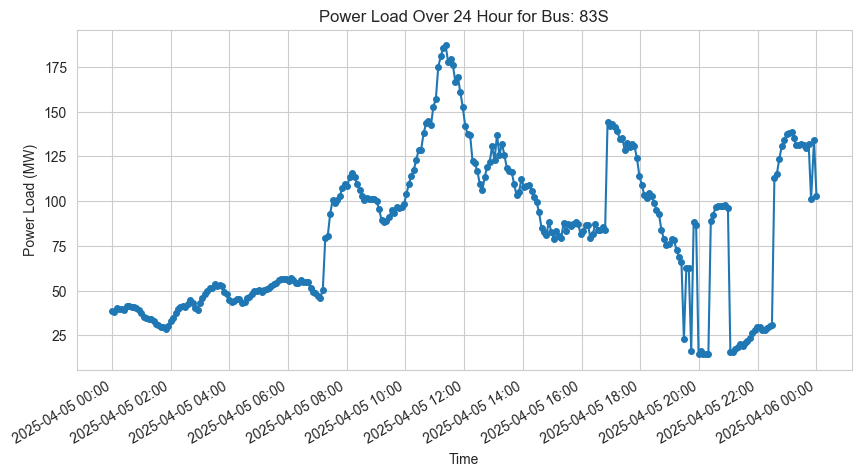

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sorted_items = sorted(final_dictionary.items())
times, values = zip(*sorted_items)

plt.figure(figsize=(10, 5))
plt.plot(times, values, marker='o', markersize=4, linestyle='-')
plt.xlabel("Time")
plt.ylabel("Power Load (MW)")
plt.title("Power Load Over 24 Hour for Bus: " + target_substation)

ax = plt.gca()
# Set the locator to show a tick every 2 hours
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.gcf().autofmt_xdate()  # Rotate date labels for clarity

plt.show()
